In [1]:
import warnings
warnings.filterwarnings("ignore")

# Aykırı Gözlem Analizi

### Aykırı Değerleri Yakalamak

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
df = sns.load_dataset("diamonds")
df = df.select_dtypes(include=["int64", "float64"])
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [106]:
df.shape

(53940, 7)

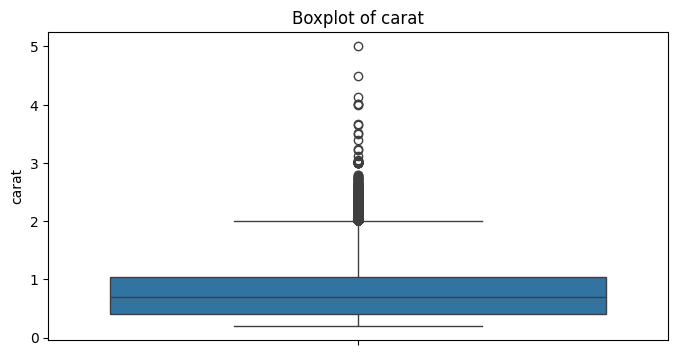

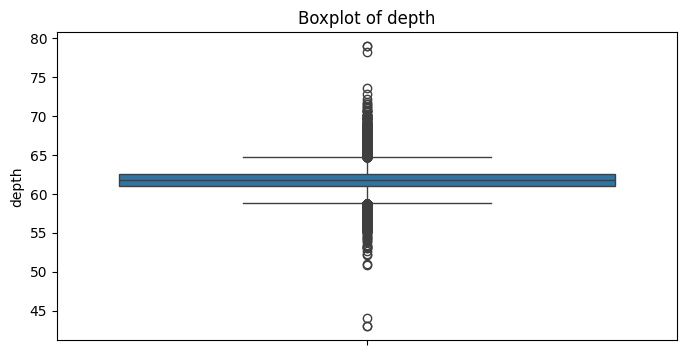

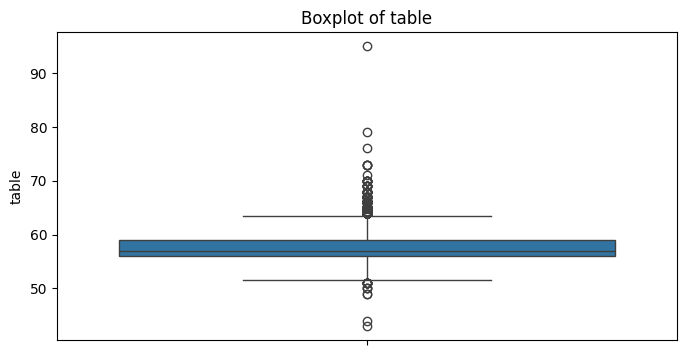

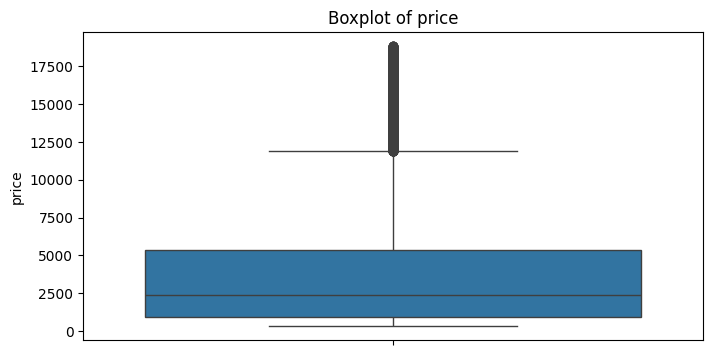

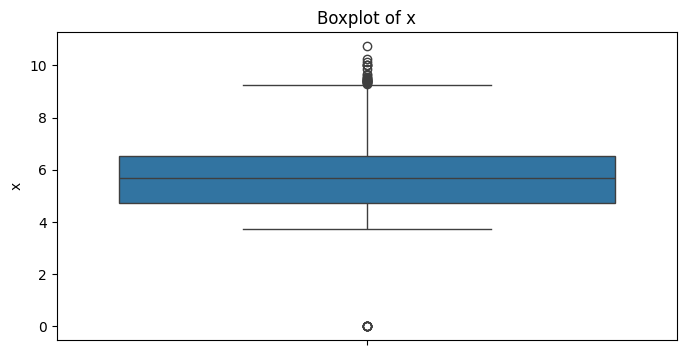

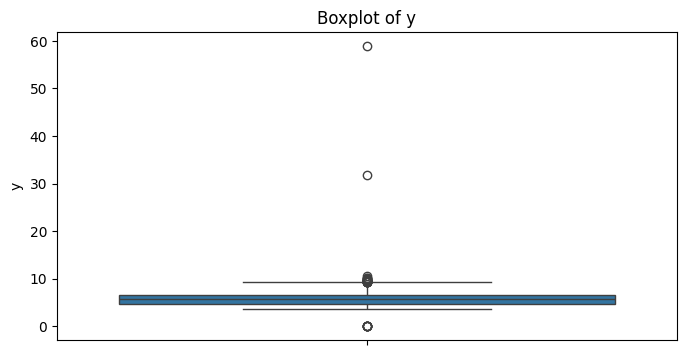

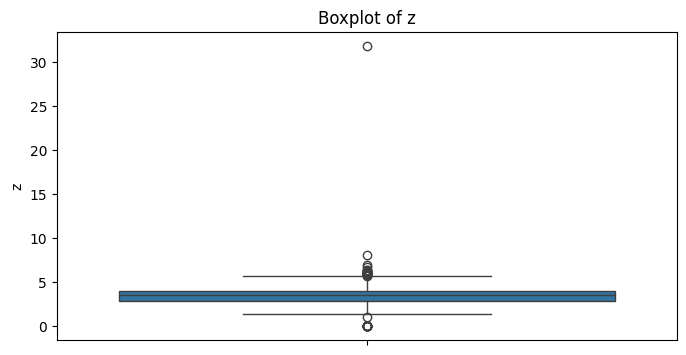

In [2]:
def plot_boxplots(df):
    # Plotting boxplots for each numerical feature to visualize outliers
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')
        plt.show()

# Call the function to plot boxplots
plot_boxplots(df)

In [ ]:
# IQR Kullanarak Aykırı Değerleri Belirleme
# IQR yöntemi, hangi veri noktalarının aykırı değer olarak kabul edildiğini belirlememize yardımcı olacaktır.

def identify_outliers_iqr(df):
    outlier_indices = {}
    
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_indices[column] = outliers.index.tolist()
    
    return outlier_indices

# Identify outliers using IQR method
outliers_dict = identify_outliers_iqr(df)

for col, vals in outliers_dict.items():
    print(f"{col} Sütunundaki aykırı değer sayısı: {len(vals)}")
    oran = (len(vals) * 100) / len(df[col])
    print(f"{col} Sütunundaki aykırı değerlerin oranı: %{round(oran, 2)}")
    print("-"*50)

carat Sütunundaki aykırı değer sayısı: 1889
carat Sütunundaki aykırı değerlerin oranı %: 3.5
--------------------------------------------------
depth Sütunundaki aykırı değer sayısı: 2545
depth Sütunundaki aykırı değerlerin oranı %: 4.72
--------------------------------------------------
table Sütunundaki aykırı değer sayısı: 605
table Sütunundaki aykırı değerlerin oranı %: 1.12
--------------------------------------------------
price Sütunundaki aykırı değer sayısı: 3540
price Sütunundaki aykırı değerlerin oranı %: 6.56
--------------------------------------------------
x Sütunundaki aykırı değer sayısı: 32
x Sütunundaki aykırı değerlerin oranı %: 0.06
--------------------------------------------------
y Sütunundaki aykırı değer sayısı: 29
y Sütunundaki aykırı değerlerin oranı %: 0.05
--------------------------------------------------
z Sütunundaki aykırı değer sayısı: 49
z Sütunundaki aykırı değerlerin oranı %: 0.09
--------------------------------------------------


In [ ]:
# LOF (Local Outlier Factor) modelini ile aykırı değer tespiti yapma: bütün sütunları aynı anda değerlendirerek aykırı gözlem analizi yapar

# LOF, bir gözlemin yerel yoğunluğunu diğer komşu gözlemlerle karşılaştırarak, o gözlemin aykırı olup olmadığını değerlendirir. 
# Yerel yoğunluk, bir veri noktasının yakınındaki veri yoğunluğuna dayanır; 
# bu nedenle LOF, özellikle yoğunluk değişimlerinin olduğu veri kümelerinde başarılıdır.


def lof_identify_outliers(df):
    outlier_indices = {}

    lof = LocalOutlierFactor(n_neighbors=20, metric="euclidean")
    lof_df = df.copy()
    # Aykırılık skorlarının hesaplanması
    lof_df['LOF_Score'] = lof.fit_predict(lof_df)
    lof_df['Outlier'] = lof_df['LOF_Score'] == -1  # LOF aykırı gözlemler için -1, olmayanlar için 1 döner
        
    # Identify outliers
    outliers = lof_df[lof_df['Outlier'] == True]
    outlier_indices['LOF_Outliers'] = outliers.index.tolist()
    
    return outlier_indices

# Identify outliers using IQR method
lof_outliers_dict = lof_identify_outliers(df)

In [105]:
lof_df[lof_df['LOF_Score'] == -1].shape

(1268, 9)

### Aykırı Değerlerin Ele Alınması

In [ ]:
# Belirlenen aykırı değerleri birkaç şekilde ele alabiliriz: 

# Aykırı Değerleri Kaldır: Aykırı değerleri içeren satırları bırakın. 
# Aykırı Değerleri Baskılama: Aykırı değerleri en yakın aykırı olmayan değerle değiştirin. 
# Verileri Dönüştürün: Uç değerlerin etkisini azaltmak için log veya karekök gibi dönüşümler uygulayın.
# Aykırı Değerleri Ortalamalarla Değiştirme:

In [ ]:
# Aykırı Değerleri Kaldır

def remove_outliers(df:pd.DataFrame, outlier_indices:dict):
    indices_set = set()
    for column, indices in outlier_indices.items():
        indices_set.update(indices)
    df.drop(list(indices_set), inplace=True)
    return df

cleaned_df_remove = remove_outliers(df.copy(), outliers_dict)
print("Aykırı değerler kaldırılmadan önce veriseti şekli:", df.shape)
print("Aykırı değerler kaldırıldıktan sonra veriseti şekli:", cleaned_df_remove.shape)
satir_orani = ((df.shape[0] - cleaned_df_remove.shape[0]) * 100) / df.shape[0]
print(f"Silinen satır oranı %: {round(satir_orani, 2)}")

Aykırı değerler kaldırılmadan önce veriseti şekli: (53940, 7)
Aykırı değerler kaldırıldıktan sonra veriseti şekli: (47524, 7)
Silinen satır oranı %: 11.89


In [ ]:
# Aykırı Değerleri Baskıla
# IQR (Interquartile Range) yöntemini kullanarak aykırı değerlerin alt ve üst sınırlarını hesaplar.
# Belirlenen sınırların dışında kalan aykırı değerleri sınır değerlerine eşitler (keser).

def cap_outliers(df, outlier_indices):
    for column, indices in outlier_indices.items():
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the values
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        
    return df

# Cap outliers in the dataset
capped_df = cap_outliers(df.copy(), outliers_dict)
print("Shape after capping outliers:", capped_df.shape) # Satır sayısı aynı kaldı

Shape after capping outliers: (53940, 7)


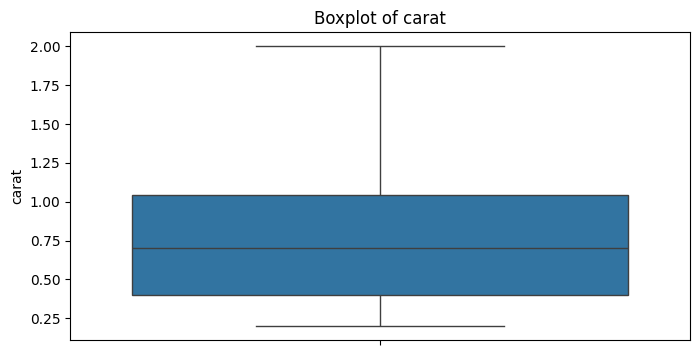

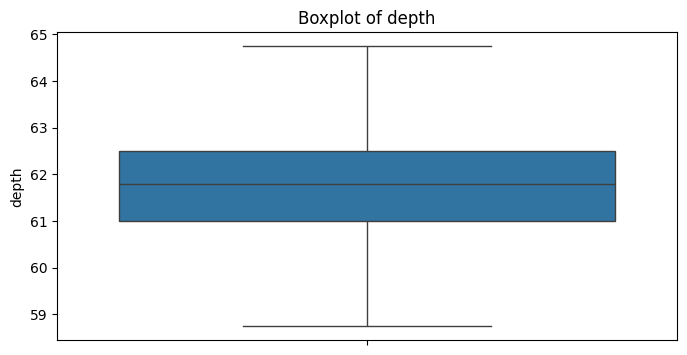

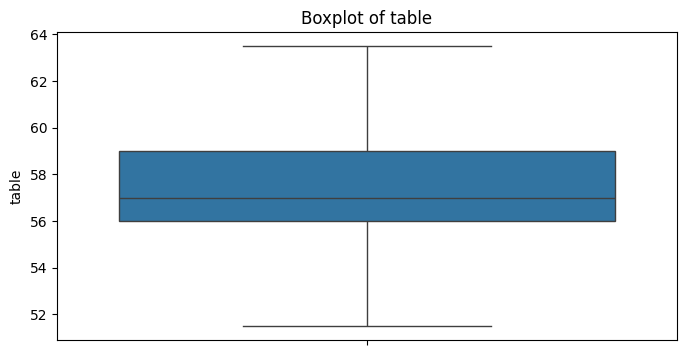

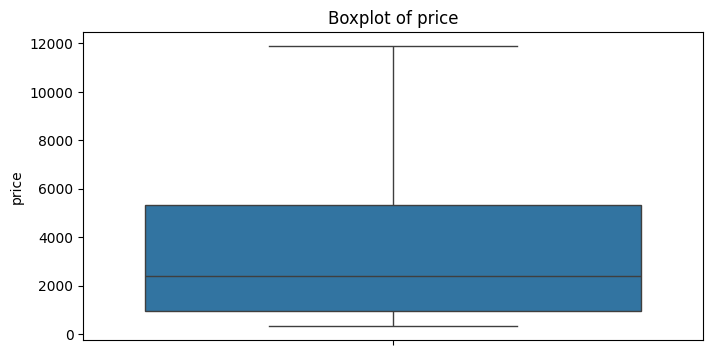

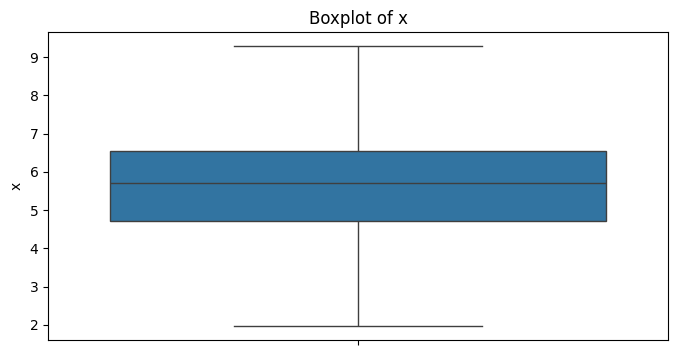

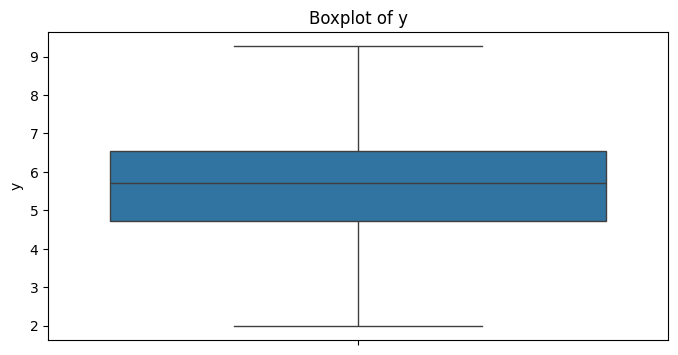

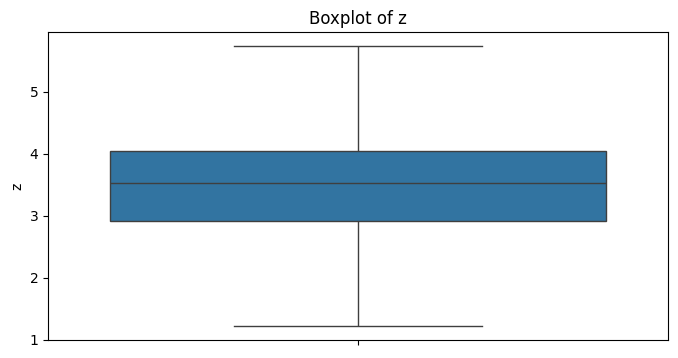

In [ ]:
# Aykırı gözlemlerin olmadığını görelim

def plot_boxplots(df):
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')
        plt.show()

plot_boxplots(capped_df)

In [21]:
# Verileri Dönüştürün: Verileri ölçeklendirerek çarpıklığı gidermeye çalışacağız

def transform_data(df):
    for column in df.columns:
        if (df[column] <= 0).any():  # Log transformation requires positive values
            continue
        df[column] = np.log(df[column])
    return df

# Transform data to reduce effect of extreme values
transformed_df = transform_data(df.copy())
print("Dönüştürülmüş veriseti:")
transformed_df.head()

Dönüştürülmüş veriseti:


,carat,depth,table,price,x,y,z
0,-1.469676,4.119037,4.007333,5.786897,3.95,3.98,2.43
1,-1.560648,4.091006,4.110874,5.786897,3.89,3.84,2.31
2,-1.469676,4.041295,4.174387,5.789960,4.05,4.07,2.31
3,-1.237874,4.133565,4.060443,5.811141,4.20,4.23,2.63
4,-1.171183,4.147885,4.060443,5.814131,4.34,4.35,2.75


In [26]:
# Aykırı Değerleri Ortalamalarla Değiştirme:

def replace_outliers_with_mean(df, outlier_indices):
    for column, indices in outlier_indices.items():
        mean_value = df[column].mean()
        df.loc[indices, column] = mean_value  # Aykırı değerleri ortalama ile değiştir
    return df

# Aykırı değerleri ortalamalarla değiştirin
cleaned_df_mean = replace_outliers_with_mean(df.copy(), outliers_dict)
print("Yeni Veri Seti:")
cleaned_df_mean.sample(5)

Yeni Veri Seti:


,carat,depth,table,price,x,y,z
50597,0.50,61.8,53.0,2283.0,5.13,5.18,3.19
42882,0.39,60.7,56.0,1359.0,4.73,4.77,2.88
5206,1.00,62.8,59.0,3780.0,6.37,6.27,3.97
33282,0.31,63.7,58.0,462.0,4.27,4.30,2.73
34074,0.40,60.9,61.0,851.0,4.75,4.78,2.90


# Eksik Gözlem Analizi

In [9]:
C1 = np.array([np.NaN,45,23,np.NaN,10,np.NaN,15])
C2 = np.array([np.NaN,5,8,20,32,65,34])
C3 = np.array([np.NaN,np.NaN,13,25,52,np.NaN,9])
df = pd.DataFrame({
    "C1": C1,
    "C2": C2,
    "C3": C3
})
df

,C1,C2,C3
0,NaN,NaN,NaN
1,45.0,5.0,NaN
2,23.0,8.0,13.0
3,NaN,20.0,25.0
4,10.0,32.0,52.0
5,NaN,65.0,NaN
6,15.0,34.0,9.0


In [10]:
df.isnull().sum()

C1    3
C2    1
C3    3
dtype: int64

In [17]:
df[df.isnull().any(axis=1)] # en az bir Eksik değer olan satırları çekmek

,C1,C2,C3
0,NaN,NaN,NaN
1,45.0,5.0,NaN
3,NaN,20.0,25.0
5,NaN,65.0,NaN


In [19]:
df[df.isnull().all(axis=1)] # tümü Eksik değer olan satırları çekmek

,C1,C2,C3
0,NaN,NaN,NaN


In [20]:
df[df.notnull().all(axis=1)] # Hiç eksik değer olmayan satırları çekmek

,C1,C2,C3
2,23.0,8.0,13.0
4,10.0,32.0,52.0
6,15.0,34.0,9.0


### Eksik Değerleri Ele Almak

In [22]:
# tüm değerleri eksik olan satırları sil

df_dropped_all = df.dropna(how='all', axis=0)
df_dropped_all

,C1,C2,C3
1,45.0,5.0,NaN
2,23.0,8.0,13.0
3,NaN,20.0,25.0
4,10.0,32.0,52.0
5,NaN,65.0,NaN
6,15.0,34.0,9.0


In [23]:
# en az bir değeri eksik olan satırları sil

df_dropped_any = df.dropna(how='any', axis=0)
df_dropped_any

,C1,C2,C3
2,23.0,8.0,13.0
4,10.0,32.0,52.0
6,15.0,34.0,9.0


In [25]:
# Silme işlemini verisetine uygulamak

drop_df = df.copy()
drop_df.dropna(how='any', axis=0, inplace=True)
drop_df

,C1,C2,C3
2,23.0,8.0,13.0
4,10.0,32.0,52.0
6,15.0,34.0,9.0


In [27]:
df

,C1,C2,C3
0,NaN,NaN,NaN
1,45.0,5.0,NaN
2,23.0,8.0,13.0
3,NaN,20.0,25.0
4,10.0,32.0,52.0
5,NaN,65.0,NaN
6,15.0,34.0,9.0


In [26]:
# Eksik değerleri sütun ortalaması ile doldur
df_filled = df.fillna(df.mean())
df_filled

,C1,C2,C3
0,23.25,27.333333,24.75
1,45.00,5.000000,24.75
2,23.00,8.000000,13.00
3,23.25,20.000000,25.00
4,10.00,32.000000,52.00
5,23.25,65.000000,24.75
6,15.00,34.000000,9.00


In [37]:
# Tahmin Yöntemi
# Makine öğrenimi algoritmaları kullanarak eksik değerleri tahmin etmek daha karmaşık bir yöntemdir ancak daha doğru sonuçlar verebilir. 
# Örneğin, KNN (K-Nearest Neighbors) algoritması kullanılabilir.

from sklearn.impute import KNNImputer

# KNN imputer ile eksik verileri doldurma
imputer = KNNImputer(n_neighbors=2) # en yakın 5 gözlemi seç
X = df.select_dtypes(include=["float64", "int64"])
cols = df.select_dtypes(include=["float64", "int64"]).columns
df_imputed = pd.DataFrame(imputer.fit_transform(X), columns=cols)

# Diğer kategorik verileri geri ekleyin (örneğin 'cut', 'color', 'clarity')
cat_cols = df.select_dtypes(include='object')
if len(cat_cols):
    df_imputed = pd.concat([df_imputed, cat_cols], axis=1, ignore_index=True)

df_imputed

,0,1,2
0,23.25,27.333333,24.75
1,45.00,5.000000,19.00
2,23.00,8.000000,13.00
3,34.00,20.000000,25.00
4,10.00,32.000000,52.00
5,12.50,65.000000,30.50
6,15.00,34.000000,9.00


### Eksik Değerleri Görselleştirme

In [1]:
!pip install missingno

In [38]:
import missingno as msno

In [3]:
# Planets veriseti üzerinde eksik değerleri görselleştirme

planets = sns.load_dataset("planets")
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [45]:
planets.isnull().sum()

method              0
number              0
orbital_period     43
mass              522
distance          227
year                0
dtype: int64

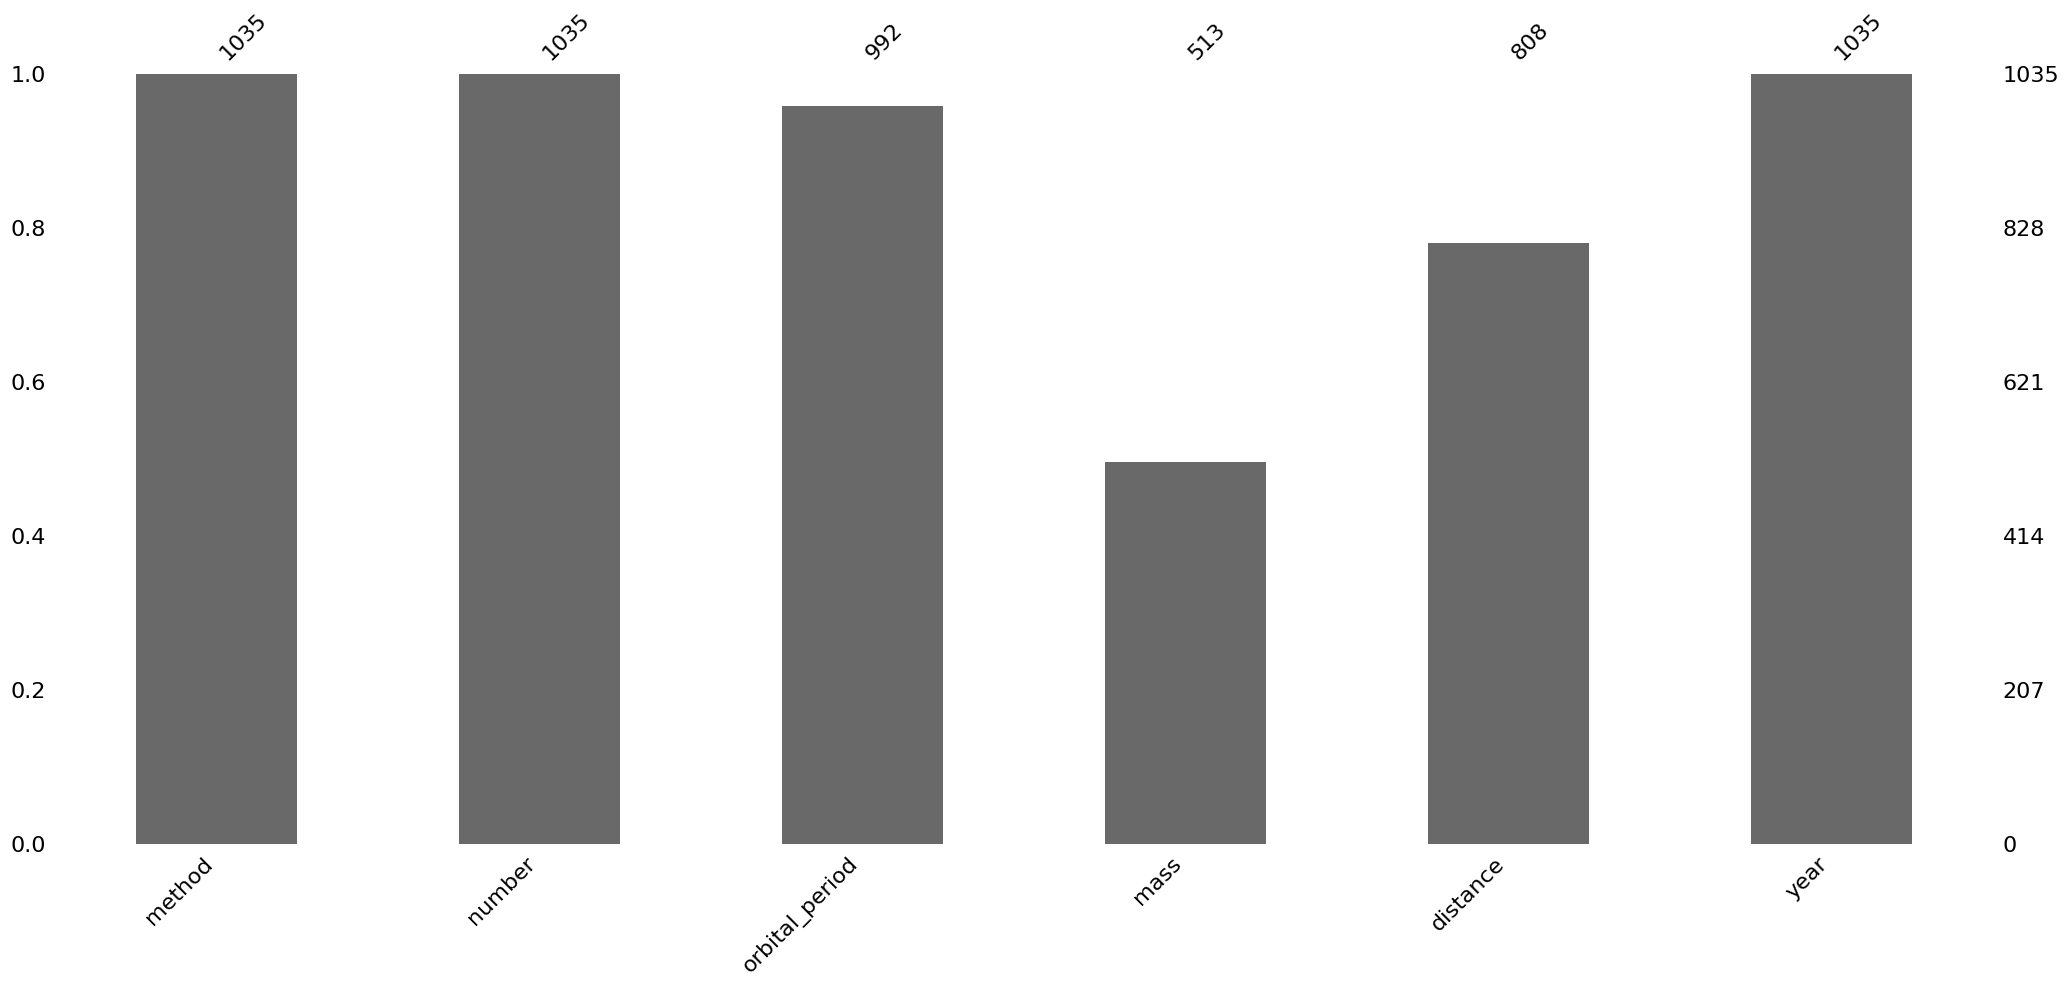

In [ ]:
msno.bar(planets); # verisetindeki eksik olmayan değer sayısı

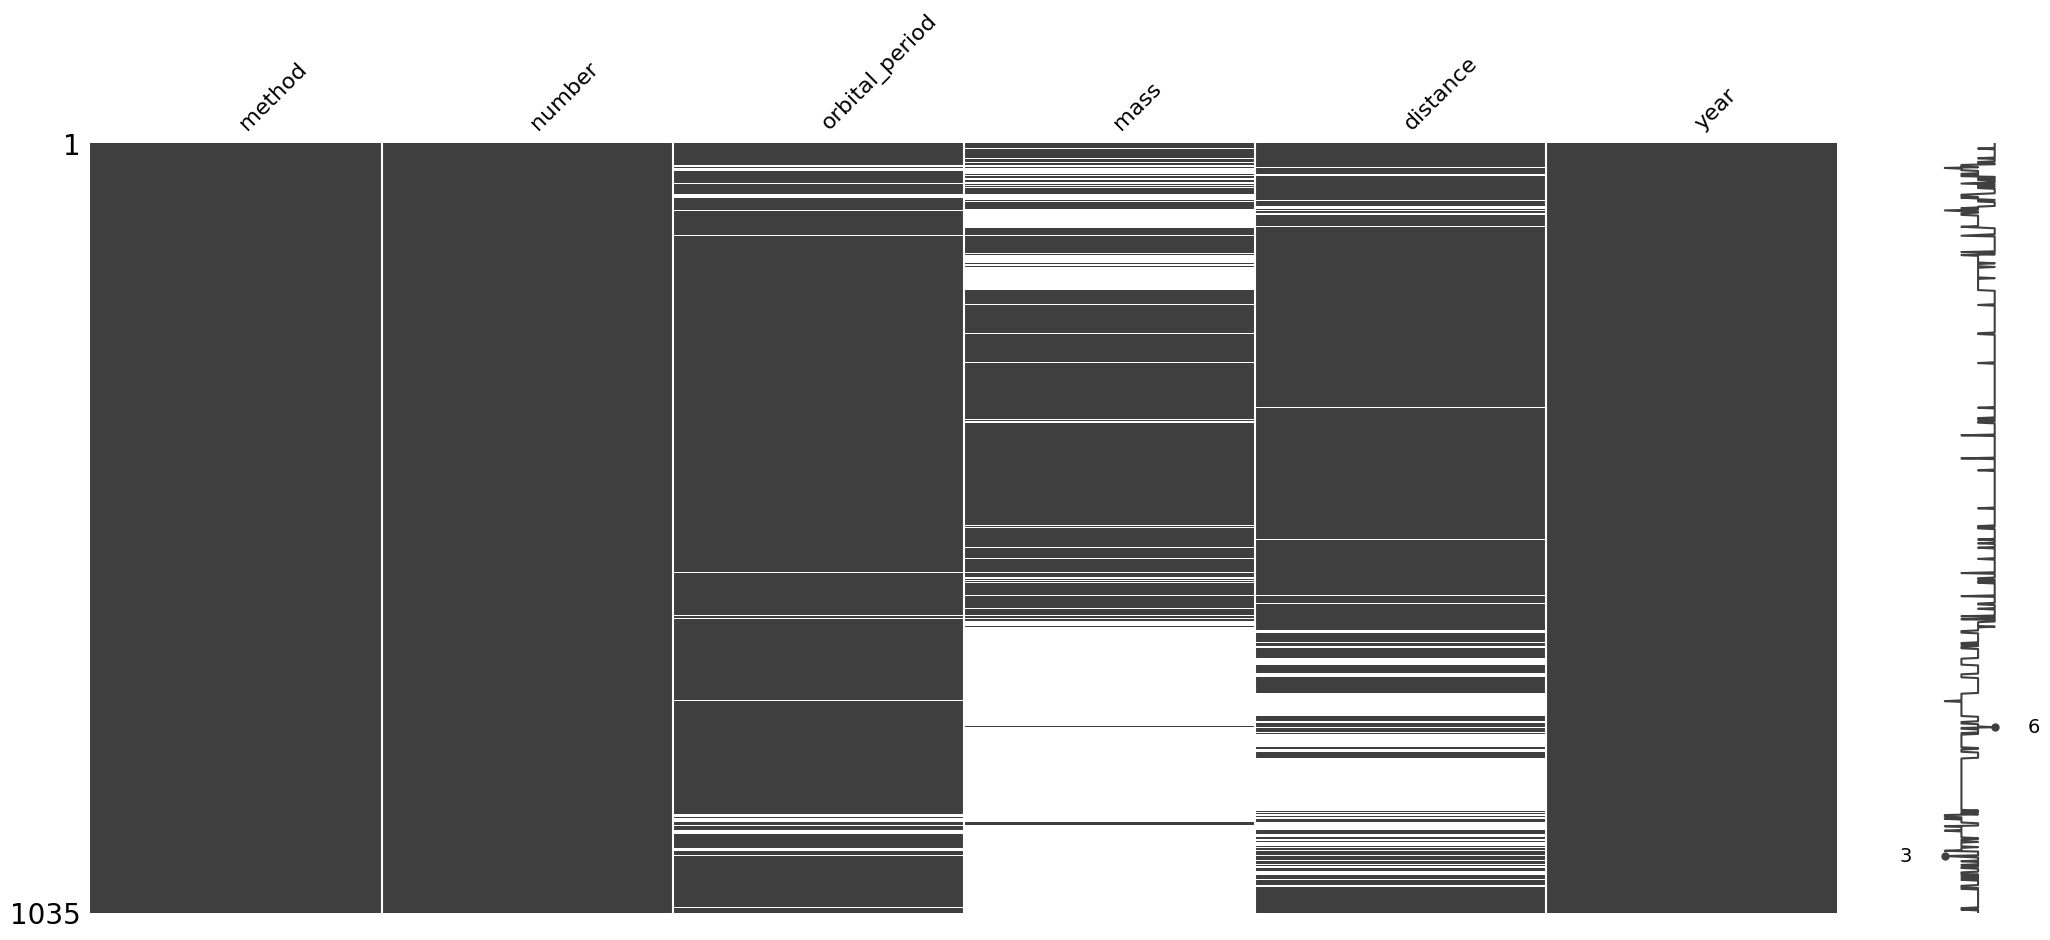

In [49]:
msno.matrix(planets); # verisetindeki eksik ve tam değerleri gösterir

## Numerik Değişken Dönüşümleri
**Makine öğrenmesinde sayısal sütunları standardize etmek, modelin daha iyi performans göstermesi, hızlı öğrenmesi ve daha doğru sonuçlar üretmesi için önemli bir adımdır.**

### scale

In [ ]:
from sklearn.preprocessing import scale
# scale: Veriyi z-skoruna (standart normal dağılım) dönüştürür. 
# Yani, her bir özellik için ortalamayı 0 ve standart sapmayı 1 yapar.

In [3]:
pens = sns.load_dataset("penguins")
pens.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
140,Adelie,Dream,40.2,17.1,193.0,3400.0,Female
12,Adelie,Torgersen,41.1,17.6,182.0,3200.0,Female
316,Gentoo,Biscoe,49.4,15.8,216.0,4925.0,Male
309,Gentoo,Biscoe,52.1,17.0,230.0,5550.0,Male
63,Adelie,Biscoe,41.1,18.2,192.0,4050.0,Male


In [53]:
num_pens = pens.select_dtypes(include=["float64","int64"]) # sadece numerik sütunları seçtik

In [62]:
num_pens.fillna(num_pens.mean(), inplace=True) # Hızlıca eksik gözlemleri giderdik

In [ ]:
scaled_data = scale(num_pens)

scaled_pens = pd.DataFrame(data=scaled_data, columns=num_pens.columns)
scaled_pens.sample(5)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
311,1.522901,-0.026025,1.934592,1.500715
302,0.639854,-1.297537,0.791756,0.655327
332,-0.077622,-0.992374,0.863183,0.561395
263,1.044584,-1.094095,1.077465,0.686637
118,-1.512573,-0.076886,-0.851070,-1.066760


### StandardScaler

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Z-skoru standardizasyonu yapar.
scaled_data = scaler.fit_transform(num_pens) # bir kez fit edildikten sonra tekrar kullanılabilir

In [64]:
scaled_pens = pd.DataFrame(data=scaled_data, columns=num_pens.columns)
scaled_pens.sample(5)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
11,-1.126240,0.075696,-1.493915,-0.628411
43,0.032759,1.296347,-0.351079,0.248288
272,0.216727,-1.399258,0.648902,0.248288
17,-0.261590,1.804952,-0.279652,0.373531
217,1.044584,0.533440,-0.565361,-0.534479


### normalize

In [65]:
from sklearn.preprocessing import normalize

# Satır bazında işlem yapar
# Özellikle mesafe tabanlı algoritmalarda (ör. k-NN, k-Means) kullanılır
normalized_data = normalize(num_pens, norm='l2') # l1, l2 veya max

In [67]:
normalized_pens = pd.DataFrame(data=normalized_data, columns=num_pens.columns)
normalized_pens.sample(5)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
138,0.010866,0.004845,0.054328,0.998452
130,0.011559,0.005374,0.057045,0.998290
217,0.013121,0.004814,0.051054,0.998598
261,0.008695,0.002805,0.039441,0.999180
31,0.009528,0.004636,0.045591,0.998904


### MinMaxScaler

In [68]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler(feature_range=(0, 1)) # verilen aralıkta ölçekleme yapar
mmscaled_data = mmscaler.fit_transform(num_pens)

In [69]:
mmscaled_pens = pd.DataFrame(data=mmscaled_data, columns=num_pens.columns)
mmscaled_pens.sample(5)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
305,0.680000,0.500000,0.949153,0.805556
216,0.414545,0.595238,0.508475,0.194444
13,0.236364,0.964286,0.322034,0.305556
31,0.185455,0.595238,0.101695,0.333333
146,0.258182,0.654762,0.305085,0.430556


## Kategorik Değişken Dönüşümleri
**Kategorik veriler üzerinde yapılan dönüşümler, algoritmaların bu verileri anlayabilmesi ve işleyebilmesi için gereklidir.**

### LabelEncoder

In [45]:
from sklearn.preprocessing import LabelEncoder

cat_pens = pens.select_dtypes(include=['object'])
cat_pens.dropna(how='any', axis=0, inplace=True)

cat_pens.head()

,species,island,sex
0,Adelie,Torgersen,Male
1,Adelie,Torgersen,Female
2,Adelie,Torgersen,Female
4,Adelie,Torgersen,Female
5,Adelie,Torgersen,Male


In [ ]:
# Kategorik verileri sayısal değerlere dönüştürmek için her kategoriye bir sayı atar.
# Genellikle hedef değişken için uygundur.


encoded_pens = pd.DataFrame()
for c in cat_pens.columns:
    encoder = LabelEncoder()
    encoded_data = encoder.fit_transform(cat_pens[c])
    encoded_pens[c] = encoded_data
    print(f"{c}: {encoder.classes_}")

encoded_pens.sample(5)

species: ['Adelie' 'Chinstrap' 'Gentoo']
island: ['Biscoe' 'Dream' 'Torgersen']
sex: ['Female' 'Male']


,species,island,sex
239,2,0,1
324,2,0,1
231,2,0,1
92,0,1,0
323,2,0,0


### OneHotEncoder

In [47]:
from sklearn.preprocessing import OneHotEncoder

# Her kategoriyi yeni bir sütun olarak temsil eder ve bu sütunlar sadece 0 veya 1 değerini alır.
# Kategorik verilerin sırasız olduğu ve her kategorinin birbirinden bağımsız olduğu durumlarda yaygın olarak kullanılır.


oh_encoded_pens = pd.DataFrame()

for c in cat_pens.columns:
    oh_encoder = OneHotEncoder(drop='first')
    cat = cat_pens[c].values.reshape(-1, 1)
    oh_encoded_data = oh_encoder.fit_transform(cat)
    column_names = [f"{c}_{category}" for category in oh_encoder.categories_[0][:-1]]

    oh_encoded_df = pd.DataFrame(oh_encoded_data.toarray(), columns=column_names, dtype='int')
    oh_encoded_pens = pd.concat([oh_encoded_pens, oh_encoded_df], axis=1)

oh_encoded_pens.sample(5)

,species_Adelie,species_Chinstrap,island_Biscoe,island_Dream,sex_Female
267,0,1,0,0,0
332,0,1,0,0,1
204,1,0,1,0,1
261,0,1,0,0,0
167,1,0,1,0,1


### OrdinalEncoder

In [57]:
# Sıralı kategorik verileri sayısal değerlere dönüştürmek için kullanılır. 
# Kategoriler sıralıdır ve sıralama bilgisini koruyarak sayılara dönüştürülür.
# Her kategoriye sıralı bir değer atanır (örneğin, "Düşük", "Orta", "Yüksek" sırasıyla 0, 1, 2).

from sklearn.preprocessing import OrdinalEncoder


encoder = OrdinalEncoder() # Birden fazla sütunda uygulanabilir

data = encoder.fit_transform(cat_pens)
oe_encoded = pd.DataFrame(data, columns=cat_pens.columns, dtype='int')

oe_encoded.sample(10)

,species,island,sex
215,2,0,1
327,2,0,1
256,2,0,1
165,1,1,1
325,2,0,0
224,2,0,0
126,0,1,0
270,2,0,1
72,0,2,0
240,2,0,1
